# Convolutional autoencoder

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torch.autograd import Variable

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

## Data

Load a custom subclass of torchvision.datasets.MNIST that instead downloads the FashionMNIST dataset 

(waiting for [this commit](https://github.com/pytorch/vision/commit/eec5ba4405c8815bd1797619d9cc9276f81b76f4) be available in the pip version of PyTorch).

In [3]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src'))
from data.fashion import FashionMNIST

Load train and test set in batches of 1000.

The `28x28` images are scaled up to `29x29` so that combining convolutions and transposed convolutions would not chop off pixels from the reconstructed images.

In [4]:
batch_size = 1000

train_dataset = FashionMNIST(
    '../data', train=True, download=True, 
    transform=transforms.Compose([transforms.CenterCrop((29, 29)), transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = FashionMNIST(
    '../data', train=False, download=True, 
    transform=transforms.Compose([transforms.CenterCrop((29, 29)), transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Unsupervised reconstruction
Note that in this section we'll never use the image labels, the whole training is unsupervised.

### Autoencoder
The two components of the autoencoder are defined subclassing `nn.Module`, that gives more flexibility than `nn.Sequential`.

#### Encoder
A series of convolutions with `kernel_size=5` and `stride=2` is used to squeeze the images into a volume of 40x1x1, then a fully connected layer turns this vector in a vector of size `embedding_size`, that can be specified externally.

#### Decoder
The decoder takes up from where the encoder left, first transforming back the embedding of size `embedding_size` into a volume of size 40x1x1, then applying a series of Transposed Convolutions to yield an image of the same size of the original input.

In [5]:
class Encoder(nn.Module):
    def __init__(self, embedding_size):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(20, 40, kernel_size=5, stride=2)
        self.fully = nn.Linear(40, embedding_size)

    def forward(self, x):
        # 1x29x29
        x = F.relu(self.conv1(x))
        # 10x13x13
        x = F.relu(self.conv2(x))
        # 20x5x5
        x = F.relu(self.conv3(x))
        # 40x1x1
        x = x.view(x.data.shape[0], 40)
        # 40
        x = self.fully(x)
        # output_size
        return x

class Decoder(nn.Module):
    def __init__(self, input_size):
        super(Decoder, self).__init__()
        self.fully = nn.Linear(input_size, 40)
        self.conv1 = nn.ConvTranspose2d(40, 20, kernel_size=5, stride=2)
        self.conv2 = nn.ConvTranspose2d(20, 10, kernel_size=5, stride=2)
        self.conv3 = nn.ConvTranspose2d(10, 1, kernel_size=5, stride=2)
    
    def forward(self, x):
        x = self.fully(x)
        x = x.view(x.data.shape[0], 40, 1, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.sigmoid(self.conv3(x))
        return x

We are going to use an embedding size of 20, this number has no particular reason, except that it is in the same range of the number of classes. Naively, the network could learn to encode coarse-grained information (i.e. the kind of dress) in half of the embedding vector and then use the other half for fine-grained information.

In [14]:
embedding_size = 20
encoder = Encoder(embedding_size)
decoder = Decoder(embedding_size)

autoencoder = nn.Sequential(encoder, decoder)

#### Sanity check
A 29x29 black and white image passed through the autoencoder should give the same output dimension

In [15]:
x = Variable(torch.ones(1, 1, 29, 29))
e = encoder(x)
d = decoder(e)

print('Input\t ', list(x.data.shape))
print('Embedding', list(e.data.shape))
print('Output\t ', list(d.data.shape))

Input	  [1, 1, 29, 29]
Embedding [1, 20]
Output	  [1, 1, 29, 29]


### Training

In [16]:
autoencoder.train()

loss_fn = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters())
epoch_loss = []

for epoch in range(15):
    batch_loss = []
    for batch_num, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        output = autoencoder(data)
        loss = loss_fn(output, data)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data[0])
    epoch_loss.append(sum(batch_loss) / len(batch_loss))
    print('Epoch {}:\tloss {:.4f}'.format(epoch, epoch_loss[-1]))

Epoch 0:	loss 0.1301
Epoch 1:	loss 0.0811
Epoch 2:	loss 0.0703
Epoch 3:	loss 0.0463
Epoch 4:	loss 0.0367
Epoch 5:	loss 0.0326
Epoch 6:	loss 0.0284
Epoch 7:	loss 0.0254
Epoch 8:	loss 0.0237
Epoch 9:	loss 0.0227
Epoch 10:	loss 0.0219
Epoch 11:	loss 0.0213
Epoch 12:	loss 0.0208
Epoch 13:	loss 0.0202
Epoch 14:	loss 0.0197


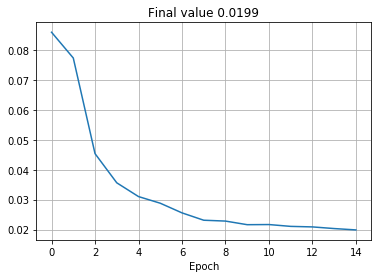

In [17]:
plt.plot(loss_history)
plt.title('Final value {:.4f}'.format(loss_history[-1]))
plt.xlabel('Epoch')
plt.grid(True)

### Evaluation

Reconsruction evaluation on a single batch

In [18]:
autoencoder.eval()
data, targets = next(test_loader.__iter__())
encodings = encoder(Variable(data))
outputs = decoder(encodings)

print('Test loss: {:.4f}'.format(loss_fn(outputs, Variable(data)).data[0]))

Test loss: 0.0197


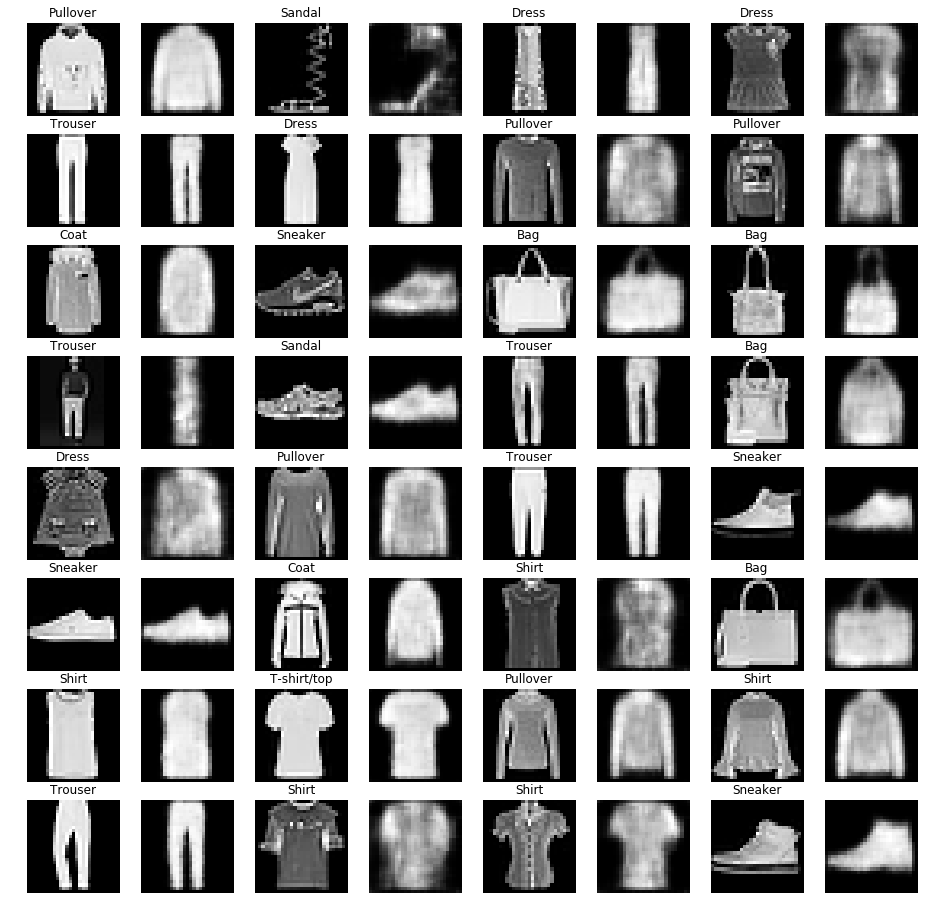

In [19]:
fig, axes = plt.subplots(8, 8, figsize=(16, 16))
axes = axes.ravel()

zip_these = axes[::2], axes[1::2], data.numpy().squeeze(), outputs.data.numpy().squeeze(), targets
for ax1, ax2, original, reconstructed, target in zip(*zip_these):
    ax1.imshow(original, cmap='gray')
    ax1.axis('off')
    ax1.set_title(FashionMNIST.labels[target])
    ax2.imshow(reconstructed, cmap='gray')
    ax2.axis('off')

### Embeddings

The embeddings are 20-dimensional, t-SNE is used to visualize them as clusters in 2D space.

Even though the autoencoder learned the embeddings in a completely unsupervised way we can observe the emergence of clusters:
- __shoes__ (sandals, sneakers and ankle boot) are clustered together
- __bags__ form a group on their own (they are the only images with a clear squared-rectangular shape)
- same goes for __trousers__, that form their own group
- all the others are quite mixed together, meaning that the network has learned the concept of _clothes for the upper body_, but is not able to tell a __coat__ from a __pullover__

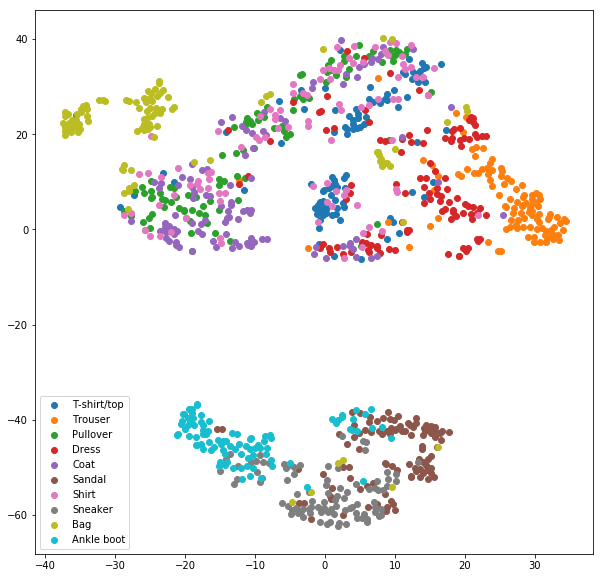

In [20]:
pca = TSNE(n_components=2)
encodings_2 = pca.fit_transform(encodings.data.numpy())
plt.figure(figsize=(10, 10))
for k in range(len(FashionMNIST.labels)):
    class_indexes = (targets.numpy() == k)
    plt.scatter(encodings_2[class_indexes, 0], encodings_2[class_indexes, 1], label=FashionMNIST.labels[k])
plt.legend();

## Supervised classification

Once trained in an unsupervised fashion, the encoder module can be used to generate _fashion_ embeddings (see what I did here?), that can then be used to train a simple classifier on the original labels.

### Model
The weights of the encoder are freezed, so only the classifier will be trained.

(later on, when the classifier starts performing decently, we could unfreeze them and do some fine-tuning)

In [21]:
for param in encoder.parameters():
    param.requires_grad = False

classifier = nn.Sequential(
    encoder, 
    nn.Linear(embedding_size, 15),
    nn.ReLU(),
    nn.Linear(15, len(FashionMNIST.labels)),
    nn.LogSoftmax()
)

### Training

In [22]:
classifier.train()

loss_fn = nn.NLLLoss()
optimizer = optim.Adam([p for p in classifier.parameters() if p.requires_grad])
epoch_loss = []

for epoch in range(15):
    batch_loss = []
    for batch_num, (data, targets) in enumerate(train_loader):
        data, targets = Variable(data), Variable(targets)
        optimizer.zero_grad()
        output = classifier(data)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data[0])
    epoch_loss.append(sum(batch_loss) / len(batch_loss))
    accuracy = accuracy_score(targets.data.numpy(), output.data.numpy().argmax(axis=1))
    print('Epoch {}:\tloss {:.4f}\taccuracy {:.2%}'.format(epoch, epoch_loss[-1], accuracy))

Epoch 0:	loss 3.9511	accuracy 45.50%
Epoch 1:	loss 1.1549	accuracy 64.50%
Epoch 2:	loss 0.9103	accuracy 68.60%
Epoch 3:	loss 0.8329	accuracy 66.40%
Epoch 4:	loss 0.7921	accuracy 69.80%
Epoch 5:	loss 0.7672	accuracy 72.00%
Epoch 6:	loss 0.7502	accuracy 70.30%
Epoch 7:	loss 0.7373	accuracy 73.60%
Epoch 8:	loss 0.7274	accuracy 74.10%
Epoch 9:	loss 0.7190	accuracy 72.80%
Epoch 10:	loss 0.7120	accuracy 76.00%
Epoch 11:	loss 0.7077	accuracy 74.90%
Epoch 12:	loss 0.7020	accuracy 74.00%
Epoch 13:	loss 0.6971	accuracy 71.80%
Epoch 14:	loss 0.6931	accuracy 74.00%


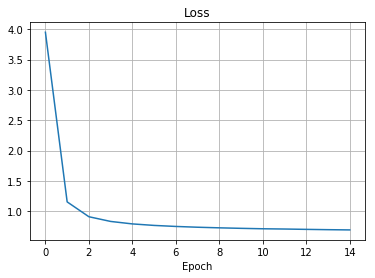

In [23]:
plt.plot(epoch_loss)
plt.title('Loss')
plt.xlabel('Epoch')
plt.grid(True)

### Evaluation

In [24]:
classifier.eval()
data, targets = next(test_loader.__iter__())
outputs = classifier(Variable(data))
log_probs, output_classes = outputs.max(dim=1)

accuracy = accuracy_score(targets.numpy(), output_classes.data.numpy())
print('Accuracy: {:.2%}'.format(accuracy))

Accuracy: 77.00%


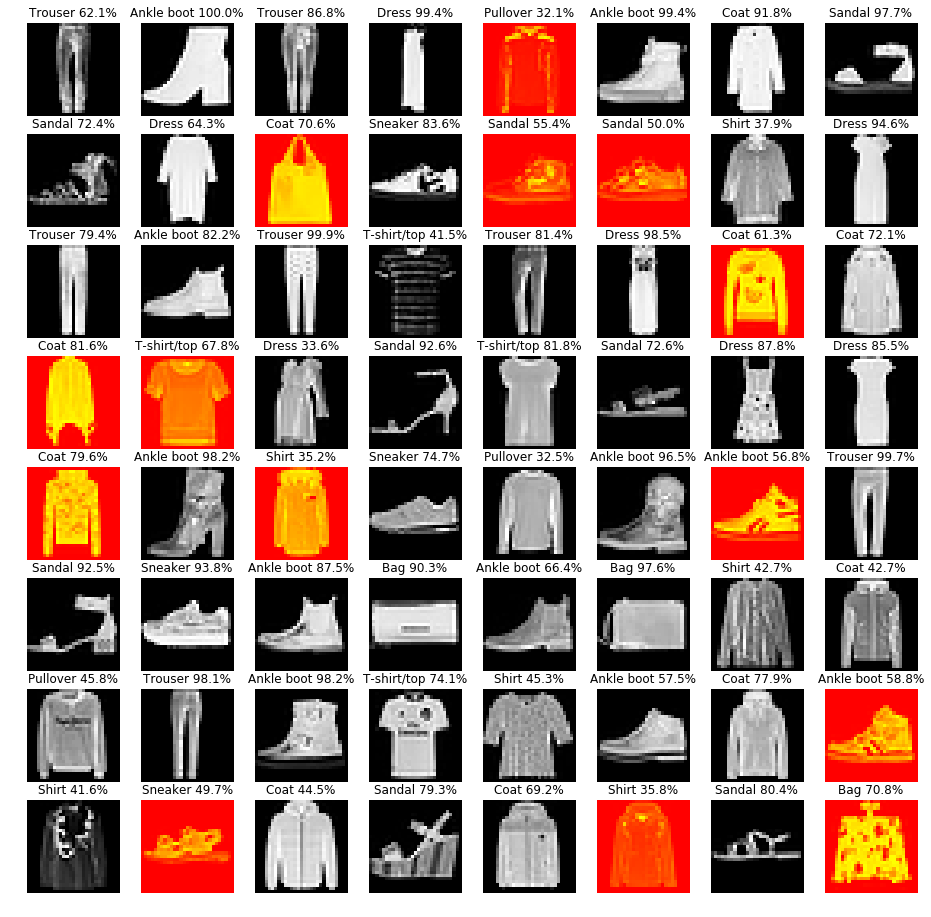

In [25]:
fig, axex = plt.subplots(8, 8, figsize=(16, 16))

zip_these = axex.ravel(), log_probs.data.exp(), output_classes.data, targets, data.numpy().squeeze()
for ax, prob, output_class, target, img in zip(*zip_these):
    ax.imshow(img, cmap='gray' if output_class == target else 'autumn')
    ax.axis('off')
    ax.set_title('{} {:.1%}'.format(FashionMNIST.labels[output_class], prob))